In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
%matplotlib inline

**Função a ser analisada**

$$f(x_1, x_2) = x_1^2 + \sin(x_1 + x_2) + x_2^4$$

**Gradiente da função**
$$\nabla f(x_1, x_2) = \left[
    \begin{array}{c}
    2 x_1 + \cos(x_1 + x_2) \\
    \cos(x_1 + x_2) + 4 x_2^3
    \end{array}
\right]$$

**Matriz Hessiana da função**
$$\nabla^{2} f(x_1, x_2) = \left[
    \begin{array}{cc}
    2 - \sin(x_1 + x_2) & - \sin(x_1 + x_2)            \\
    - \sin(x_1 + x_2)   & - \sin(x_1 + x_2) + 12 x_2^2
    \end{array}
\right]$$

**Calculando os pontos críticos**

$$\nabla f(x_1, x_2) = \left[
    \begin{array}{c}
    2 x_1 + \cos(x_1 + x_2) \\
    \cos(x_1 + x_2) + 4 x_2^3
    \end{array}
\right] = \left[ 
    \begin{array}{c}
    0 \\
    0 
    \end{array}
\right]$$

In [45]:
# Definição da função f(x1,x2)
def f(x: np.array) -> np.float64:
    x1 = x[0][0]
    x2 = x[1][0]
    return x1**2 + np.sin(x1+x2) + x2**4

# Gradiente calculado para a função f(x1,x2)
def grad(x: np.array) -> np.ndarray:
    x1 = x[0][0]
    x2 = x[1][0]
    return np.array(
        [2*x1 + np.cos(x1+x2), np.cos(x1+x2) + 4*x2**3],
        dtype=np.float64
    )

# Cálculo da matriz Hessiana da função f(x1,x2)
def hessian(x: np.array) -> np.ndarray:
    x1 = x[0][0]
    x2 = x[1][0]
    return np.array(
        [
            [2 - np.sin(x1+x2), -np.sin(x1+x2)],
            [-np.sin(x1+x2)   , -np.sin(x1+x2) + 12*x2**2 ],
        ],
        dtype=np.float64
    )

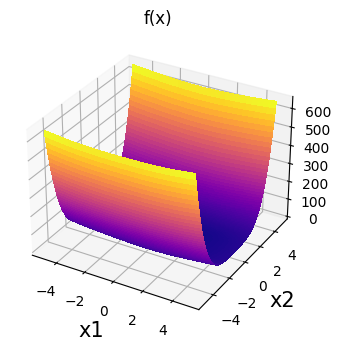

In [46]:
x1 = np.linspace(-5,5,150)
x2 = np.linspace(-5,5,150)
x1, x2 = np.meshgrid(x1, x2)
fig = plt.figure(figsize=(13,13))
x = np.array(([x1],[x2]))
z = f(x)
ax = fig.add_subplot(131, projection='3d')
ax.set_xlabel('x1',fontsize=15)
ax.set_ylabel('x2',fontsize=15)
ax.set_zlabel('z',fontsize=15)
ax.set_title('f(x)');
surf1 = ax.plot_surface(x1, x2, z, rstride=1, cstride=1,linewidth=0, antialiased=False,cmap='plasma',label='f(x1,x2)')


In [47]:
hf = hessian(([2.0], [2.0]))

print('\nMatriz Hessiana de f(2, 2) calculada diretamente\n', hf)


Matriz Hessiana de f(2, 2) calculada diretamente
 [[ 2.7568025  0.7568025]
 [ 0.7568025 48.7568025]]


**Definição de Armijo** 

###### A busca de Armijo será utilizada para encontrar o passo de descida **t** ideal para todos os métodos de obteção do(s) ponto(s) mínimos(s) implementados.

In [48]:
def armijo(f, grad, x0: np.array, d, gama, n, t=1):
    assert n < 1
    assert n > 0
    iter = 0
    x = x0
    while f(x+t*d) > (f(x)+ n*t*np.dot(grad(x).T,d)):
        if iter == 200:
            print('Limite de iteracoes atingido')
            return(x+t*d,iter)
        t = gama*t
        iter += 1
    return(x+t*d,iter) 

**Método de Newton**

Abaixo é implementado o método de Newton com os seguintes critérios de parada:

* $\nabla f(x^k) = 0$ gradiente igual a zero no ponto em questão;

* $k > 1000$ número de iterações k é superior a 1000;

* $x^k = x^{k-1}$ ponto de mínimo permaneceu o mesmo por uma iteração.

In [59]:
# Primeiro invertemos a matriz Hessiana, a fim de utilizar a inversa no algoritmo

def invert_quad_matrix(hessian, x: np.array):
    mat = hessian(x)

    det = (mat[0][0] * mat[1][1]) - (mat[0][1] * mat[1][0])

    if det == 0:
        raise ValueError('Matriz é singular e não pode ser invertida.')
    else:
        inv_mat = 1.0 / det * np.array(([mat[1][1],-mat[0][1]],[-mat[1][0],mat[0][0]]),dtype='double')
    return inv_mat


In [54]:
def newton_method(funcao, grad, x0: np.array, gama, n, err, use_armijo=False):
    x = x0
    k = 0
    iter_armijo = 0
    erro = 0

    while not (np.allclose(grad(x),[[0.0],[0.0]], atol=err, rtol=0)):
            erro = np.abs(grad(x)-[[0.0],[0.0]])
            tmp = x
            inversa = invert_quad_matrix(hessian,x)
            d = -1*np.dot(inversa, grad(x))
            if use_armijo:
                x, i_armijo = armijo(funcao, grad, x, d, gama, n, use_armijo)
                iter_armijo += i_armijo
            else:
                x = x + 1*d
            if (np.allclose(x, tmp, rtol=0, atol=err) and k>40):
                print('Condicao de parada atingida - ponto x de minimo nao modificado em uma iteracao')
                return(x, k, iter_armijo,erro) 
            k += 1
            if k > 1000:
                print('Condicao de parada - numero max de iteracoes (k = 100) superado')
                return(x, k, iter_armijo,erro)
                
    print(f'Metodo convergiu para tolerancia: {err}')
    return(x, k, iter_armijo, erro)

In [64]:
otimoNtn,kNtn,armNtn,erroNtn = newton_method(f, grad, [[3.0],[-3.0]], 0.7, 0.5, 1e-5, use_armijo=True)
print(f'Para t = 1:\notimo:\n{otimoNtn}\nIteracoes:{kNtn}\nArmijoCalls:{armNtn}\nResultado de f: {f(otimoNtn)}')

Condicao de parada atingida - ponto x de minimo nao modificado em uma iteracao
Para t = 1:
otimo:
[[ 3.  3.]
 [-3. -3.]]
Iteracoes:41
ArmijoCalls:4410
Resultado de f: 90.0
